# ***INSTALL DEPENDENCIES*** #

In [1]:
import os
import os.path as op
import tarfile
from zipfile import ZipFile
from urllib.request import urlretrieve


def create_folder(folder):
    if not op.exists(folder):
        os.mkdir(folder)
        print(f"Creating:\t\t {folder}")
    else:
        print(f"Already exist:\t\t {folder}")

def download_file(url, filename):
    if not op.exists(filename):
        print(f"Downloading:\t\t {url} --> {filename}")
        urlretrieve(url, filename)
    else:
        print(f"Already downloaded:\t {url} --> {filename}")

def extract_file(main, filename, foldername):
    if not op.exists(foldername):
        print(f'Extracting:\t\t {filename} --> {foldername}')
        file_extension = os.path.splitext(filename)[1].lower()
        if file_extension == '.zip':
            with ZipFile(filename, 'r') as zip_ref:
                zip_ref.extractall(main)
        elif file_extension in ('.tar', '.gz', '.bz2', '.xz'):
            with tarfile.open(filename, 'r:*') as tar_ref:
                tar_ref.extractall(path=main)
        else:
            print(f"Unsupported file type: {file_extension}")
    else:
        print(f'Already extracted:\t {filename} --> {foldername}')


FILES = "Files"
DOG_URL = "https://raw.githubusercontent.com/KeremDUZENLI/python-keras-deep-learning/main/notebooks/Files/dog.jpg"
DOG_FILE = FILES + "/dog.jpg"
IMAGENET_URL = "https://raw.githubusercontent.com/KeremDUZENLI/python-keras-deep-learning/main/notebooks/Files/imagenet_tool.py"
IMAGENET_FILE = FILES + "/imagenet_tool.py"
META_CLSLOC_URL = "https://raw.githubusercontent.com/KeremDUZENLI/python-keras-deep-learning/main/notebooks/Files/meta_clsloc.mat"
META_CLSLOC_FILE = FILES + "/meta_clsloc.mat"
WEIGHTS_DENSE_URL = "https://raw.githubusercontent.com/KeremDUZENLI/python-keras-deep-learning/main/notebooks/Files/weights_dense.h5"
WEIGHTS_DENSE_FILE = FILES + "/weights_dense.h5"

create_folder(FILES)
download_file(DOG_URL, DOG_FILE)
download_file(IMAGENET_URL, IMAGENET_FILE)
download_file(META_CLSLOC_URL, META_CLSLOC_FILE)
download_file(WEIGHTS_DENSE_URL, WEIGHTS_DENSE_FILE)

Already exist:		 Files
Already downloaded:	 https://raw.githubusercontent.com/KeremDUZENLI/python-keras-deep-learning/main/notebooks/Files/dog.jpg --> Files/dog.jpg
Already downloaded:	 https://raw.githubusercontent.com/KeremDUZENLI/python-keras-deep-learning/main/notebooks/Files/imagenet_tool.py --> Files/imagenet_tool.py
Already downloaded:	 https://raw.githubusercontent.com/KeremDUZENLI/python-keras-deep-learning/main/notebooks/Files/meta_clsloc.mat --> Files/meta_clsloc.mat
Already downloaded:	 https://raw.githubusercontent.com/KeremDUZENLI/python-keras-deep-learning/main/notebooks/Files/weights_dense.h5 --> Files/weights_dense.h5


# Step 1: Setting Up the Environment

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread as scipy_imread
from skimage.transform import resize as scipy_imresize
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras.layers import Convolution2D, Input
from keras import backend as K
import warnings


# Wrapper functions to suppress warnings
def imread(*args, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return scipy_imread(*args, **kwargs)

def imresize(*args, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return scipy_imresize(*args, **kwargs)

# Set random seed for reproducibility
np.random.seed(1)
print("Random integers:", np.random.randint(0, 100, 10))

Random integers: [37 12 72  9 75  5 79 64 16  1]


# Step 2: Loading the Pretrained ResNet50 Model

In [5]:
# Load ResNet50 without the top layer
base_model = ResNet50(include_top=False, weights='imagenet')
print("\nBase model output shape:", base_model.output_shape)

# Inspect the last layer
res5c = base_model.layers[-1]
print("\nType of last layer:", type(res5c))
print("\nOutput shape of last layer:", res5c.output_shape)


Base model output shape: (None, None, None, 2048)

Type of last layer: <class 'keras.layers.core.Activation'>

Output shape of last layer: (None, None, None, 2048)


# Step 3: Transforming into a Fully Convolutional Network

In [6]:
from keras.layers import Layer


class SoftmaxMap(Layer):
    def __init__(self, axis=-1, **kwargs):
        self.axis = axis
        super(SoftmaxMap, self).__init__(**kwargs)

    def build(self, input_shape):
        pass  # No trainable parameters

    def call(self, x, mask=None):
        e = K.exp(x - K.max(x, axis=self.axis, keepdims=True))
        s = K.sum(e, axis=self.axis, keepdims=True)
        return e / s

    def get_output_shape_for(self, input_shape):
        return input_shape


# Let's check that we can use this layer to normalize the classes probabilities of some random spatial predictions:
n_samples, w, h, n_classes = 10, 3, 4, 5
random_data = np.random.randn(n_samples, w, h, n_classes)
print("\nRandom Data Shape:", random_data.shape)

# Because those predictions are random, if we some accross the classes dimensions we get random values instead of class probabilities that would need to some to 1:
print("\nRandom Data Sum:\n", random_data[0].sum(axis=-1))


Random Data Shape: (10, 3, 4, 5)

Random Data Sum:
 [[ 1.2915484   0.71316334  2.15712456 -0.32802452]
 [-0.66935419  1.29604846 -1.81986543 -0.65993333]
 [-0.14876657  1.84387823  1.44881943 -1.11416513]]


## Step 3.1: Use softmax

In [8]:
from keras.models import Sequential


# Create a sequential model with a Softmax mapping layer
model = Sequential([SoftmaxMap(input_shape=(w, h, n_classes))])
print("\nModel Output Shape (after Softmax layer):", model.output_shape)

# Apply the model to the input data and store the transformed values
softmax_mapped_data = model.predict(random_data)
print("\nShape of Softmax Mapped Data:", softmax_mapped_data.shape)

# First sample of the softmax output to observe the transformation
print("\nSoftmax Mapped Data (First Sample):\n", softmax_mapped_data[0])

# Verify that the softmax transformation ensures the sum of probabilities is 1 for each spatial position
print("\nSum of probabilities per spatial location (should be ~1):\n", softmax_mapped_data[0].sum(axis=-1))

# Find the index of the highest activation in the original data before applying softmax
print("\nMost activated class index before Softmax:\n", random_data[0].argmax(axis=-1))

# Find the index of the highest activation in the softmax-transformed data
print("\nMost activated class index after Softmax:\n", softmax_mapped_data[0].argmax(axis=-1))


Model Output Shape (after Softmax layer): (None, 3, 4, 5)

Shape of Softmax Mapped Data: (10, 3, 4, 5)

Softmax Mapped Data (First Sample):
 [[[0.1018749  0.31669027 0.17417216 0.29647437 0.11078833]
  [0.13923359 0.20509481 0.25645742 0.20751648 0.1916977 ]
  [0.05377047 0.15338491 0.11877228 0.32533997 0.34873232]
  [0.23942856 0.13670343 0.10504285 0.3038679  0.21495716]]

 [[0.14350583 0.21141568 0.10887805 0.40677544 0.12942488]
  [0.41346902 0.1819199  0.22000568 0.04065668 0.14394875]
  [0.46241033 0.08496129 0.16896264 0.22780971 0.05585611]
  [0.23573759 0.4009034  0.07282388 0.24422887 0.04630623]]

 [[0.1433569  0.02961439 0.45735073 0.22428852 0.14538942]
  [0.03115902 0.24177836 0.48365277 0.01055166 0.23285815]
  [0.5091364  0.14020097 0.03013831 0.23708305 0.08344142]
  [0.10278031 0.05495179 0.3260504  0.41543302 0.10078442]]]

Sum of probabilities per spatial location (should be ~1):
 [[1.         1.         1.         0.99999994]
 [0.9999999  1.         1.0000001  1.

## Step 3.2: Build the fully convolutional model

In [9]:
input = base_model.input
x = base_model.output
x = Convolution2D(1000, (1, 1), name='conv_1000')(x)  # 1x1 conv for 1000 classes
output = SoftmaxMap(axis=-1)(x)

fully_conv_ResNet = Model(inputs=input, outputs=output)
print("\nFully convolutional model output shape (batch_size, height, width, num_classes):", fully_conv_ResNet.output_shape)

# You can use the following random data to check that it's possible to run a forward pass on a random RGB image:
prediction_maps = fully_conv_ResNet.predict(np.random.randn(1, 224, 224, 3))
print("\nShape of model output on a single random input image:", prediction_maps.shape)
print("\nSum of softmax probabilities at each spatial position (should be ~1):\n", prediction_maps.sum(axis=-1))


Fully convolutional model output shape (batch_size, height, width, num_classes): (None, None, None, 1000)

Shape of model output on a single random input image: (1, 7, 7, 1000)

Sum of softmax probabilities at each spatial position (should be ~1):
 [[[0.9999995  0.99999976 0.9999998  1.0000002  1.0000002  1.0000005
   0.9999999 ]
  [1.0000005  1.0000004  1.0000004  0.9999999  1.         1.
   0.99999976]
  [1.0000007  1.0000002  0.9999993  0.9999998  0.99999976 1.0000005
   1.0000007 ]
  [1.0000008  0.9999995  1.0000002  0.99999994 0.9999999  1.0000001
   1.0000002 ]
  [0.9999994  1.         1.         0.99999875 0.99999964 0.9999997
   1.0000007 ]
  [0.99999917 1.0000008  1.0000005  0.99999976 0.99999976 0.9999997
   0.9999993 ]
  [0.9999995  0.99999905 0.9999999  1.         0.9999995  1.0000004
   0.99999964]]]


# Step 4: Loading Pretrained Dense Weights

In [10]:
import h5py


# Load weights from the dense layer
with h5py.File(WEIGHTS_DENSE_FILE, 'r') as h5f:
    w = h5f['w'][:]
    b = h5f['b'][:]

last_layer = fully_conv_ResNet.layers[-2]
print("\nLoaded weight shape:", w.shape)
print("\nLast conv layer weights shape:", last_layer.get_weights()[0].shape)

# Reshape weights for convolutional layer
w_reshaped = w.reshape((1, 1, 2048, 1000))  # (kernel_height, kernel_width, input_channels, output_channels)

# Set weights for the convolutional layer
conv_layer = fully_conv_ResNet.get_layer('conv_1000')
conv_layer.set_weights([w_reshaped, b])


Loaded weight shape: (2048, 1000)

Last conv layer weights shape: (1, 1, 2048, 1000)


# Step 5: Performing a Forward Pass


Image shape before resizing: (1600, 2560, 3)

Image batch shape before forward pass: (1, 224, 224, 3)

Prediction map shape: (1, 7, 7, 1000)


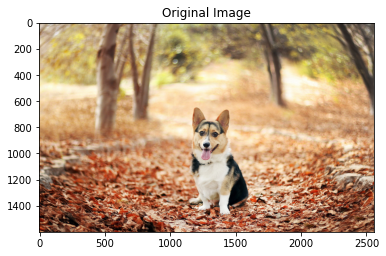

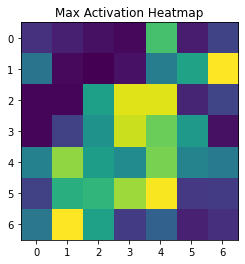

In [12]:
def forward_pass_resize(img_path, img_size):
    img_raw = imread(img_path)
    print("\nImage shape before resizing:", img_raw.shape)
    img = imresize(img_raw, img_size, mode='reflect', preserve_range=True).astype("float32")
    img = preprocess_input(img[np.newaxis])
    print("\nImage batch shape before forward pass:", img.shape)
    z = fully_conv_ResNet.predict(img)
    return z, img_raw

# Test with dog.jpg
output, input_img = forward_pass_resize("Files/dog.jpg", (224, 224))
print("\nPrediction map shape:", output.shape)

# Visualize
plt.imshow(input_img)
plt.title("Original Image")
plt.show()

plt.imshow(output[0].max(axis=-1))
plt.title("Max Activation Heatmap")
plt.show()

# Step 6: Generating Dog-Specific Heatmaps

In [13]:
from Files.imagenet_tool import *


# Dog synset
synset = "n02084071" # synset corresponding to dogs
ids = synset_to_dfs_ids(synset)
print("\nAll dog class IDs (%d): \n%s" % (len(ids), ids))

print('\nTop 10 Dog Names:')
for dog_id in ids[:10]:
    print(id_to_words(dog_id))


All dog class IDs (118): 
[251, 268, 256, 253, 255, 254, 257, 159, 211, 210, 212, 214, 213, 216, 215, 219, 220, 221, 217, 218, 207, 209, 206, 205, 208, 193, 202, 194, 191, 204, 187, 203, 185, 192, 183, 199, 195, 181, 184, 201, 186, 200, 182, 188, 189, 190, 197, 196, 198, 179, 180, 177, 178, 175, 163, 174, 176, 160, 162, 161, 164, 168, 173, 170, 169, 165, 166, 167, 172, 171, 264, 263, 266, 265, 267, 262, 246, 242, 243, 248, 247, 229, 233, 234, 228, 231, 232, 230, 227, 226, 235, 225, 224, 223, 222, 236, 252, 237, 250, 249, 241, 239, 238, 240, 244, 245, 259, 261, 260, 258, 154, 153, 158, 152, 155, 151, 157, 156]

Top 10 Dog Names:
dalmatian, coach dog, carriage dog
Mexican hairless
Newfoundland, Newfoundland dog
basenji
Leonberg
pug, pug-dog
Great Pyrenees
Rhodesian ridgeback
vizsla, Hungarian pointer
German short-haired pointer


## Step 6.1: Heatmap (400, 640)-(800, 1280)-(1600, 2560)


Image shape before resizing: (1600, 2560, 3)

Image batch shape before forward pass: (1, 400, 640, 3)

Heatmap shape: (13, 20)


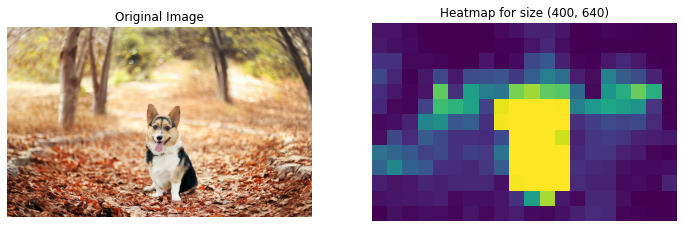


Image shape before resizing: (1600, 2560, 3)

Image batch shape before forward pass: (1, 800, 1280, 3)

Heatmap shape: (25, 40)


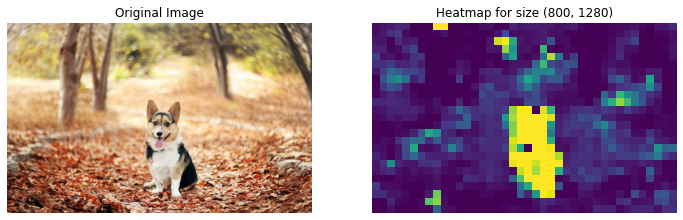


Image shape before resizing: (1600, 2560, 3)

Image batch shape before forward pass: (1, 1600, 2560, 3)

Heatmap shape: (50, 80)


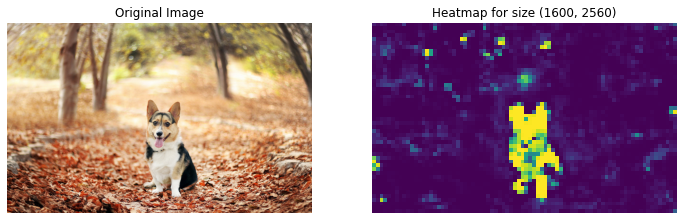

In [14]:
# Builds Heatmaps
def build_heatmap(z, synset):
    class_ids = synset_to_dfs_ids(synset)
    class_ids = np.array([id_ for id_ in class_ids if id_ is not None and id_ < 1000])  # Filter valid IDs
    x = z[0, :, :, class_ids].sum(axis=0)
    print("\nHeatmap shape:", str(x.shape))
    return x

# Displays the original image and the corresponding heatmap side by side.
def display_img_and_heatmap(img_path, heatmap, size):
    dog = imread(img_path)
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 8))
    
    ax0.imshow(dog)
    ax0.set_title("Original Image")
    ax0.axis("off")
    ax1.imshow(heatmap, interpolation='nearest', cmap="viridis")
    ax1.set_title(f"Heatmap for size {size}")
    ax1.axis("off")
    plt.show()


# Generate heatmaps at different scales
sizes = [(400, 640), (800, 1280), (1600, 2560)]
heatmaps = []
for size in sizes:
    output, _ = forward_pass_resize("Files/dog.jpg", size)
    heatmap = build_heatmap(output, synset)
    heatmaps.append(heatmap)
    
    # Display the original image and the heatmap
    display_img_and_heatmap("Files/dog.jpg", heatmap, size)

# Step 7: Combining Heatmaps

Combined Heatmap (Geometric Mean)


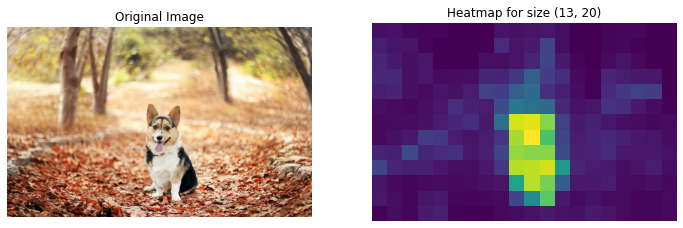

In [15]:
from skimage.transform import resize


# Resize heatmaps to the same size and compute geometric mean
target_size = heatmaps[0].shape
resized_heatmaps = [resize(h, target_size, mode='reflect', preserve_range=True) for h in heatmaps]

# Geometric mean
heatmap_geom_avg = np.exp(np.mean([np.log(h + 1e-10) for h in resized_heatmaps], axis=0))

# Display the original image and the final combined heatmap
print("Combined Heatmap (Geometric Mean)")
display_img_and_heatmap("Files/dog.jpg", heatmap_geom_avg, target_size)